In [ ]:
import os
import json
import pandas as pd
import torch
from datetime import datetime
from sentence_transformers import SentenceTransformer
from torch_geometric.data import HeteroData
import numpy as np
import torch_geometric.transforms as transf
from torch.nn import ModuleDict, ModuleList, Linear, Sequential, ReLU
from torch_geometric.nn import HeteroConv, GATv2Conv

np.random.seed(42)

path = r"C:\Users\MainUser\project\cs224w_cb_graph\info_folder\score.json"
records = []

with open(path, "r", encoding="utf-8") as f:

    data = json.load(f)

    for entry in data:

        speech_id  = entry["id"]
        tone_score = entry['gpt-5']

        for topic, score in tone_score.items():
            records.append({
                "speech_id": speech_id,
                "topic": topic,
                "tone_score": score
            })

score_df = pd.DataFrame(records)
score_df["tone_norm"] = score_df.groupby("topic")["tone_score"].transform(
    lambda x: (x - x.mean()) / x.std()
)
score_df.head()

,speech_id,topic,tone_score,tone_norm
0,feddsp:95906,Fed Funds Rate,0.0,-0.201565
1,feddsp:95906,Labor Market,0.0,-0.387294
2,feddsp:95906,Inflation,0.0,-0.525486
3,feddsp:95906,Real Activity,0.0,-0.351968
4,feddsp:95906,Financial Stability,-0.5,-2.117084


In [ ]:
text_data_folder      = r"C:\Users\MainUser\project\cs224w_cb_graph\text_data"
speakers              = []
speech_by_ids         = {}
speech_dates_by_ids   = {}
speakers_by_ids       = {}

for filename in os.listdir(text_data_folder):

    if not filename.endswith(".json"):
        continue

    path = os.path.join(text_data_folder, filename)
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for entry in data:
        speech_id = entry["id"]
        speech_by_ids[speech_id] = entry.get("text", "")
        speech_dates_by_ids[speech_id] = datetime.strptime(entry["date"], "%Y-%m-%d")
        speakers_by_ids[speech_id] = entry["author"]
        speakers += [entry["author"]]

speech_ids = sorted(list(speech_by_ids.keys()))
speakers   = sorted(list(set(speakers)))
topics     = sorted(score_df["topic"].unique())


In [ ]:
embedder   = SentenceTransformer("all-MiniLM-L6-v2")

speech_embeddings = (
    embedder.encode([speech_by_ids[i] for i in speech_ids], normalize_embeddings=True))
topic_embeddings    = embedder.encode(topics, normalize_embeddings=True)
speakers_embeddings = embedder.encode(speakers, normalize_embeddings=True)

print(f"\nGenerated: \n"
      f"{len(speech_embeddings)} speech embeddings \n"
      f"{len(speakers_embeddings)} speaker embeddings \n"
      f"{len(topic_embeddings)} topic embeddings.")


Generated: 
55 speech embeddings 
2 speaker embeddings 
6 topic embeddings.


In [ ]:
# add nodes
data = HeteroData()
data["speech"].x = torch.tensor(speech_embeddings, dtype=torch.float)
data["topic"].x = torch.tensor(topic_embeddings, dtype=torch.float)
data["speaker"].x = torch.tensor(speakers_embeddings, dtype=torch.float)

In [ ]:
speech_to_idx  = {sid: i for i, sid in enumerate(speech_ids)}
topic_to_idx   = {t: i for i, t in enumerate(topics)}
speaker_to_idx = {s: i for i, s in enumerate(speakers)}

speech_to_topic_edge_index = []
speech_to_topic_edge_attr = []

for _, row in score_df.iterrows():

    s_idx = speech_to_idx[row["speech_id"]]
    t_idx = topic_to_idx[row["topic"]]
    speech_to_topic_edge_index.append([s_idx, t_idx])
    speech_to_topic_edge_attr.append([row["tone_norm"]])

speech_to_topic_edge_index = torch.tensor(speech_to_topic_edge_index, dtype=torch.long).t().contiguous()
speech_to_topic_edge_attr = torch.tensor(speech_to_topic_edge_attr, dtype=torch.float)

data["speech", "discusses", "topic"].edge_index = speech_to_topic_edge_index
data["speech", "discusses", "topic"].edge_attr = speech_to_topic_edge_attr

In [ ]:
speech_sorted  = sorted(speech_dates_by_ids.items(), key=lambda x: x[1])
temporal_edges = []
time_diffs     = []

for i in range(len(speech_sorted) - 1):
    src = speech_to_idx[speech_sorted[i][0]]
    dst = speech_to_idx[speech_sorted[i + 1][0]]
    temporal_edges.append([src, dst])

temporal_edges = torch.tensor(temporal_edges, dtype=torch.long).t().contiguous()
temporal_pairs = temporal_edges.t().tolist()
time_diffs = []
for src, dst in temporal_pairs:
    src_id = list(speech_to_idx.keys())[list(speech_to_idx.values()).index(src)]
    dst_id = list(speech_to_idx.keys())[list(speech_to_idx.values()).index(dst)]
    delta_days = (speech_dates_by_ids[dst_id] - speech_dates_by_ids[src_id]).days
    time_diffs.append(delta_days)

time_diffs = np.array(time_diffs, dtype=float)
data["speech", "follows", "speech"].edge_index = temporal_edges
data["speech", "follows", "speech"].edge_attr = torch.tensor(time_diffs, dtype=torch.float).unsqueeze(1)

In [ ]:
speech_speaker_edges = []
for speech_id, author_name in speakers_by_ids.items():
    sp_idx = speech_to_idx[speech_id]
    author_idx = speaker_to_idx[author_name]
    speech_speaker_edges.append([author_idx, sp_idx])
speech_speaker_edges = torch.tensor(speech_speaker_edges, dtype=torch.long).t().contiguous()
data["speaker", "authored", "speech"].edge_index = speech_speaker_edges


In [ ]:
influence_path = r"C:\Users\MainUser\project\cs224w_cb_graph\info_folder\author_maps.json"

with open(influence_path, "r", encoding="utf-8") as f:
    influence_data = json.load(f)

speaker_topic_edges = []

for entry in influence_data:
    speaker_name = entry.get("author_key")
    influence_topics = entry.get("influence", [])
    if len(influence_topics) == 0:
        continue

    print(f"author_key: {speaker_name}")

    speaker_idx = speaker_to_idx[speaker_name]

    for topic in influence_topics:
        topic_idx = topic_to_idx[topic]
        speaker_topic_edges.append([speaker_idx, topic_idx])

speaker_topic_edges = torch.tensor(speaker_topic_edges, dtype=torch.long).t().contiguous()
data["speaker", "influences", "topic"].edge_index = speaker_topic_edges

data = transf.ToUndirected(data)


author_key: l:logan-lorie
author_key: p:powell-jerome-h


In [ ]:
print(data)
print("Node types:", data.node_types)
print("Edge types:", data.edge_types)

print("Speech–Topic edges:", data["speech", "discusses", "topic"].edge_index.shape)
print("Speech–Speech temporal edges:", data["speech", "follows", "speech"].edge_index.shape)
print("Speech–Speech temporal edges:", data["speech", "follows", "speech"].edge_attr.shape)
print("Speech–Speaker edges:", data["speaker", "authored", "speech"].edge_index.shape)

HeteroData(
  speech={ x=[55, 384] },
  topic={ x=[6, 384] },
  speaker={ x=[2, 384] },
  (speech, discusses, topic)={
    edge_index=[2, 306],
    edge_attr=[306, 1],
  },
  (speech, follows, speech)={
    edge_index=[2, 54],
    edge_attr=[54, 1],
  },
  (speaker, authored, speech)={ edge_index=[2, 55] },
  (speaker, influences, topic)={ edge_index=[2, 8] }
)
Node types: ['speech', 'topic', 'speaker']
Edge types: [('speech', 'discusses', 'topic'), ('speech', 'follows', 'speech'), ('speaker', 'authored', 'speech'), ('speaker', 'influences', 'topic')]
Speech–Topic edges: torch.Size([2, 306])
Speech–Speech temporal edges: torch.Size([2, 54])
Speech–Speech temporal edges: torch.Size([54, 1])
Speech–Speaker edges: torch.Size([2, 55])


In [ ]:
result_folder = r"C:\Users\MainUser\project\cs224w_cb_graph\info_folder"
torch.save(data, os.path.join(result_folder, "fed_speech_graph.pt"))

In [ ]:
import networkx as nx

G = nx.DiGraph()

for i in range(data['speech'].num_nodes):
    G.add_node(f"S_{i}", node_type="speech", color="skyblue")

for i in range(data['topic'].num_nodes):
    G.add_node(f"T_{i}", node_type="topic", color="salmon")

for i in range(data['speaker'].num_nodes):
    G.add_node(f"A_{i}", node_type="speaker", color="lightgreen")


In [ ]:
import numpy as np

pos = {}
for i in range(data["speech"].num_nodes):
    pos[f"S_{i}"] = (i, np.random.uniform(-0.2, 0.2))

for i in range(data["topic"].num_nodes):
    pos[f"T_{i}"] = (np.random.uniform(0, data["speech"].num_nodes), np.random.uniform(-3, -3))

for i in range(data["speaker"].num_nodes):
    pos[f"A_{i}"] = (np.random.uniform(0, data["speech"].num_nodes), np.random.uniform(2, 2))


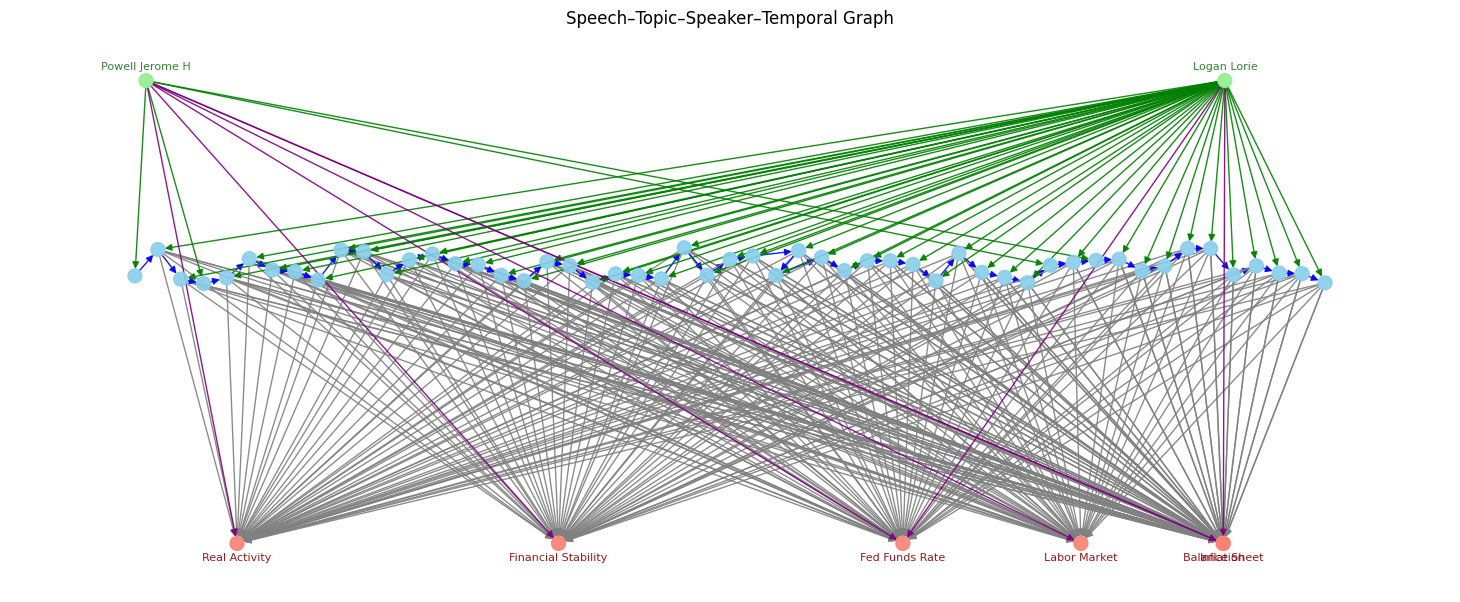

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

for src, dst in data["speech", "discusses", "topic"].edge_index.t().tolist():
    G.add_edge(f"S_{src}", f"T_{dst}", color="gray")

for src, dst in data["speech", "follows", "speech"].edge_index.t().tolist():
    G.add_edge(f"S_{src}", f"S_{dst}", color="blue")

for src, dst in data["speaker", "authored", "speech"].edge_index.t().tolist():
     G.add_edge(f"A_{src}", f"S_{dst}", color="green")

for src, dst in data["speaker", "influences", "topic"].edge_index.t().tolist():
    G.add_edge(f"A_{src}", f"T_{dst}", color="purple")

dates_series = pd.Series(speech_dates_by_ids).sort_values()
date_to_x = {sid: i for i, sid in enumerate(dates_series.index)}

pos = {}
for sid in speech_ids:
    if sid in date_to_x:
        x = date_to_x[sid]
        y = np.random.uniform(-0.2, 0.2)
        pos[f"S_{speech_to_idx[sid]}"] = (x, y)

for i in range(data["topic"].num_nodes):
    pos[f"T_{i}"] = (
        np.random.uniform(0, len(dates_series)),
        np.random.uniform(-3, -3),
    )

for i in range(data["speaker"].num_nodes):
    pos[f"A_{i}"] = (
        np.random.uniform(0, len(dates_series)),
        np.random.uniform(2, 2),
    )

# --- 4. Draw ---
edge_colors = [G[u][v]["color"] for u, v in G.edges()]
node_colors = [G.nodes[n].get("color", "red") for n in G.nodes()]

fig, ax = plt.subplots(figsize=(16, 7))

nx.draw(
    G,
    pos,
    node_color=node_colors,
    edge_color=edge_colors,
    node_size=100,
    with_labels=False,
    arrows=True,
    alpha=0.9,
    ax=ax        # <--- this ensures labels stick
)

ax.set_title("Speech–Topic–Speaker–Temporal Graph")
ax.set_xlabel("Date: Chronological Order of Speeches")
ax.set_ylabel("Node layers: Topics ↓ / Speeches / Speakers ↑")

# --- Add speaker labels (annotations) ---
for i, speaker_name in enumerate(speakers):
    node_key = f"A_{i}"
    if node_key in pos:
        x, y = pos[node_key]
        plt.text(
            x,
            y + 0.1,
            speaker_name.split(":")[-1].replace("-", " ").title(),
            fontsize=8,
            ha="center",
            va="bottom",
            color="darkgreen",
            alpha=0.8
        )

# --- Annotate topics (below) ---
for i, topic_name in enumerate(topics):
    node_key = f"T_{i}"
    if node_key in pos:
        x, y = pos[node_key]
        plt.text(
            x,
            y - 0.1,
            topic_name,
            fontsize=8,
            ha="center",
            va="top",
            color="darkred",
            alpha=0.9,

        )

plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
output_path = r"C:\Users\MainUser\project\cs224w_cb_graph\fed_speech_graph.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


In [ ]:
class hetero_attn(torch.nn.Module):
  #uses GATv2Conv for each of the layers before prediction heads
  def __init__ (self, hidden, heads, layers):
    super().__init__()

    #dict mapping node types to learnable linear transformations of appropriate
    #dimension

    self.by_type = ModuleDict()
    self.by_type["speech"] = Linear(data["speech"].x.shape[1], hidden)
    self.by_type["topic"] = Linear(data["topic"].x.shape[1], hidden)
    self.by_type["speaker"] = Linear(data["speaker"].x.shape[1], hidden)

    self.convs = torch.nn.ModuleList()
    for i in range(layers):
      layer = HeteroConv({
          ("speech", "discusses", "topic"): GATv2Conv(-1, hidden, heads=heads, edge_dim=1),
          ("speech", "follows", "speech"): GATv2Conv(-1, hidden, heads=heads, edge_dim=1),
          ("speaker", "authored", "speech"): GATv2Conv(-1, hidden, heads=heads),
          ("speaker", "influences", "topic"): GATv2Conv(-1, hidden, heads=heads),

          ("topic", "rev_discusses", "speech"): GATv2Conv(-1, hidden, heads=heads, edge_dim=1),
          ("speech", "rev_follows", "speech"): GATv2Conv(-1, hidden, heads=heads, edge_dim=1),
          ("speech", "rev_authored", "speaker"): GATv2Conv(-1, hidden, heads=heads),
          ("topic", "rev_influences", "speaker"): GATv2Conv(-1, hidden, heads=heads),
      }, aggr="mean")

      self.convs.append(layer)

      #output layer is a matrix mapping from vector space of the "hidden" dimension
      #to the number of prediction heads (used for time series later)
      self.dim_final = hidden * heads

    def forward (self, params_map, edge_idx_map, edge_attr_map):
      #apply matrix followed by nonlinear activation (ReLU) for each node type

      for node_type, x in params_map.items():
        params_map[node_type] = self.by_type[node_type](x).relu()

      for layer in self.convs:
        params_map = layer(params_map, edge_idx_map, edge_attr_map)
        params_map = {k : x.relu() for k, x in params_map.items()}

      return params_map

In [ ]:
class time_series_pred(torch.nn.Module):
  def __init__ (self, param_dict, hidden, layers, heads, pred_dim):
    super().__init__()

    #take info from the GNN embeddings and define dims for final linear
    #transformation
    self.gnn = hetero_attn(hidden=hidden, layers=layers, heads=heads)
    dim_final = self.gnn.dim_final

    #multilayer perceptron, apply relu activation then extract single score
    self.pred = Sequential(Linear(dim_final * 2, pred_dim * 2), ReLU(), Linear(pred_dim * 2, 1))

  def forward (self, data,  topic_idx, speech_idx):

    #dict to store edge attributes only (by type)
    edge_attrs = {}
    for edge_type, features in data.edge_store.items():
      if "edge_attr" in features:
        edge_attrs[edge_type] = features.edge_attr

    #build embeddings map w/gnn
    embeddings_map = self.gnn(data.params_map, data.edge_idx_map, edge_attrs)
    topic_emb = embeddings_map["topic"][topic_idx]
    speech_emb = embeddings_map["speech"][speech_idx]

    concat = torch.cat([speech_emb, topic_emb], dim=-1)
    dovish_hawkish = self.pred(concat)

    return dovish_hawkish.squeeze(-1)

In [7]:
import glob
import json

# Find all .json files in a folder
json_files = glob.glob(r"C:\Users\MainUser\project\cs224w_cb_graph\text_data\*.json")
print(len(json_files))
num = 0
for json_file in json_files:
    with open(json_file, encoding='utf-8') as f:
        data = json.load(f)
        num += len(data)

print(num)



27
2241
